Jump to the last cell for final plot

# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM
import matplotlib

import matplotlib.patches as patches
from scipy.interpolate import interp1d
from matplotlib import cm


# S250328ae

In [36]:
# Define events with start times and observation MJD times
events = {
    "S250328ae": {
        "chirp_mass": 11.96 + 9.0 - 5.84 ,
        "total_mass": 28.93 + 22.4 - 14.23,
        "dL": 492.33,
        "start": '2025-03-28 00:00:00',
        "obs_mjd": [60763., 60764., 60771., 60790.],
        "pfs_obs_mjd": [60768.],
        "obs_depths": {
            "decam1": {"z": 21.4, "r": 22.7, "i": 22.1},
            "decam2": {"z": 21.9, "r": 22.8, "i": 22.5},
            "decam3": {"z": 21.0, "r": 21.3, "i": 21.2},
            "decam4": {"z": 21.6, "r": 22.3, "i": 22.1},
            "pfs1": {"blue": 21.3, "red": 21.3, "nir": 19.6}
        },
    }
}


In [37]:
event_total_mass = [events[key]["total_mass"] for key in events.keys()]
event_total_mass = np.array(event_total_mass)
event_total_mass

array([37.1])

Compute epochs wrt to event start date

In [38]:
# Compute epochs
all_epochs = {}
for event, data in events.items():
    start_time = Time(data["start"], format='iso')
    obs_times = Time(data["obs_mjd"], format='mjd')
    all_epochs[event] = (obs_times - start_time).to_value('day')

# Print results
epochs = []
for event, ep in all_epochs.items():
    epochs.append(ep)
    print(f"{event}: {ep}")

S250328ae: [ 1.  2.  9. 28.]


In [39]:
# obs depths
obs_depths = {}
for event, data in events.items():
    obs_depths[event] = data.get("obs_depths", {})
    print(f"{event}: {obs_depths[event]}")

S250328ae: {'decam1': {'z': 21.4, 'r': 22.7, 'i': 22.1}, 'decam2': {'z': 21.9, 'r': 22.8, 'i': 22.5}, 'decam3': {'z': 21.0, 'r': 21.3, 'i': 21.2}, 'decam4': {'z': 21.6, 'r': 22.3, 'i': 22.1}, 'pfs1': {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [40]:
epochs

[array([ 1.,  2.,  9., 28.])]

Model functions

In [41]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, a, aspect_ratio, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (a / 700) 
        * (M_SMBH / 10**8) 
        * (aspect_ratio / 0.01)
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity+50) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency

Fiducial Model:
- vk: variable
- rho0: variable
- height: 700rg * 0.01 (fixed for all cases later)
- mp_optical_depth: C*rho0
- theta: 60 deg (fixed for all cases later)
- radiative_efficiency (fixed)
- mSMBH (fixed)


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [42]:
# Define the parameters for the grid
# Main Parameters
vk_array = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) # km/s   
rho_array = np.logspace(-3, -13, num=11, base=10)

# Other parameters
a = 700 # rg
aspect_ratio = 0.01
height_array = aspect_ratio * a #[0.001, 0.01, 0.1])

C = 10**12
#mp_optical_depth = C * rho_array

theta_array = np.array([60]) #[30, 45, 60, 75])

vk_grid, rho_grid = np.meshgrid(vk_array, rho_array, indexing='ij')

# Fixed parameters
radiative_efficiency = 0.1
mSMBH = 10**8

#vk_grid, rho_grid

In [43]:
# Start times

sig_start_times = t_ram(event_total_mass, vk_grid)

peak_times = 2 * sig_start_times
peak_luminosities = L_BHL(event_total_mass, vk_grid, rho_grid, radiative_efficiency)

# End times
#exit_times = t_exit(height_grid, mp_optical_depth_grid, vk_grid)

#peak_times = np.where(peak_times > end_times, end_times, peak_times)
end_times = t_end(mSMBH, vk_grid, a, aspect_ratio, theta_array[0])

Lightcurves

In [44]:
# Define the light curve model
'''def gaussian_rise(rise_array, peak_lumi):
    t = rise_array 
    tg = rise_array[-1] - rise_array[0]
    t0 = rise_array[-1]
    return peak_lumi * np.exp(-((t - t0) ** 2) / (2 * tg ** 2))'''


'''def exponential_decay(fall_array, peak_lumi):
    t = fall_array 
    t0 = fall_array[0]
    te = fall_array[-1] - fall_array[0]
    return peak_lumi * np.exp(-(t - t0) / te)'''

def gaussian_rise(rise_array, peak_lumi):
    t = rise_array
    t0 = t[-1]                 # peak at end
    tg = t0 - t[0]             # width
    start_val = np.exp(-((t[0] - t0)**2) / (2 * tg**2))
    return peak_lumi * (np.exp(-((t - t0)**2) / (2 * tg**2)) - start_val) / (1 - start_val)



def exponential_decay(fall_array, peak_lumi):
    t = fall_array
    t0 = t[0]
    t_end = t[-1]
    te = t_end - t0
    # Normalized so f(t0)=peak_lumi, f(t_end)=0
    return peak_lumi * (np.exp(-(t - t0) / te) - np.exp(-(t_end - t0) / te)) / (1 - np.exp(-(t_end - t0) / te))


def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis


Use solar magnitudes to obtain griz band mags

In [45]:
'''# Constants
L_sun = 3.828e33  # Solar luminosity in erg/s
M_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes

# Extract distance for each event
dLs = np.array([events[key]["dL"] for key in events.keys()])  

# Function to convert luminosity to absolute magnitude
def luminosity_to_mag(L, band):
    return M_sun[band] - 2.5 * np.log10(L / L_sun)

# Function to convert absolute magnitude to apparent magnitude
def absolute_to_apparent_mag(M_band, d_L):
    return M_band + 5 * np.log10(d_L) + 25

def luminosity_to_apparant_mag(L, d_L, band):
    M_band = luminosity_to_mag(L, band)
    return absolute_to_apparent_mag(M_band, d_L)

L = np.array(peak_luminosities)  

# Compute magnitudes for each band
mags = {}

for band in ["g", "r", "i", "z"]:
    # Compute absolute magnitudes per event
    M_band = luminosity_to_mag(L, band)
    
    # Compute apparent magnitudes per event
    mags[band] = absolute_to_apparent_mag(M_band, dLs)

print("Apparent Magnitudes (griz bands):", mags)'''

'# Constants\nL_sun = 3.828e33  # Solar luminosity in erg/s\nM_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes\n\n# Extract distance for each event\ndLs = np.array([events[key]["dL"] for key in events.keys()])  \n\n# Function to convert luminosity to absolute magnitude\ndef luminosity_to_mag(L, band):\n    return M_sun[band] - 2.5 * np.log10(L / L_sun)\n\n# Function to convert absolute magnitude to apparent magnitude\ndef absolute_to_apparent_mag(M_band, d_L):\n    return M_band + 5 * np.log10(d_L) + 25\n\ndef luminosity_to_apparant_mag(L, d_L, band):\n    M_band = luminosity_to_mag(L, band)\n    return absolute_to_apparent_mag(M_band, d_L)\n\nL = np.array(peak_luminosities)  \n\n# Compute magnitudes for each band\nmags = {}\n\nfor band in ["g", "r", "i", "z"]:\n    # Compute absolute magnitudes per event\n    M_band = luminosity_to_mag(L, band)\n    \n    # Compute apparent magnitudes per event\n    mags[band] = absolute_to_apparent_mag(M_band, dLs)\n\n

Use blackbody approximation for SED

In [46]:
'''# Load DECam filter transmission data
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)
wav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:, 2]
filter_r = bandpasses[:, 3]
filter_i = bandpasses[:, 4]
filter_z = bandpasses[:, 5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]

# Plot DECam transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='DECam g', color='limegreen', lw=2)
plt.plot(wav, filter_r, label='DECam r', color='tomato', lw=2)
plt.plot(wav, filter_i, label='DECam i', color='gold', lw=2)
plt.plot(wav, filter_z, label='DECam z', color='purple', lw=2)

# PFS band definitions (in Angstroms)
pfs_bands = {
    'PFS Blue': {'range': (3800, 6500), 'cwl': 5150, 'color': 'dodgerblue'},
    'PFS Red': {'range': (6300, 9700), 'cwl': 8000, 'color': 'crimson'},
    'PFS NIR': {'range': (9400, 12600), 'cwl': 11000, 'color': 'brown'}
}

# Add shaded regions for PFS arms
for name, info in pfs_bands.items():
    x_min, x_max = info['range']
    plt.axvspan(x_min, x_max, color=info['color'], alpha=0.15, label=f"{name} coverage")
    plt.axvline(info['cwl'], color=info['color'], ls='--', lw=1)

# Plot formatting
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Transmission', fontsize=12)
plt.title('DECam Filter Transmission Curves with PFS Band Coverage', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()'''

'# Load DECam filter transmission data\nbandpasses = np.loadtxt(\'decam_transmission_curves.txt\', skiprows=1)\nwav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms\nfilter_g = bandpasses[:, 2]\nfilter_r = bandpasses[:, 3]\nfilter_i = bandpasses[:, 4]\nfilter_z = bandpasses[:, 5]\n\n# Ensure wavelength is sorted\nsort_idx = np.argsort(wav)\nwav = wav[sort_idx]\nfilter_g = filter_g[sort_idx]\nfilter_r = filter_r[sort_idx]\nfilter_i = filter_i[sort_idx]\nfilter_z = filter_z[sort_idx]\n\n# Plot DECam transmission curves\nplt.figure(figsize=(10, 6))\nplt.plot(wav, filter_g, label=\'DECam g\', color=\'limegreen\', lw=2)\nplt.plot(wav, filter_r, label=\'DECam r\', color=\'tomato\', lw=2)\nplt.plot(wav, filter_i, label=\'DECam i\', color=\'gold\', lw=2)\nplt.plot(wav, filter_z, label=\'DECam z\', color=\'purple\', lw=2)\n\n# PFS band definitions (in Angstroms)\npfs_bands = {\n    \'PFS Blue\': {\'range\': (3800, 6500), \'cwl\': 5150, \'color\': \'dodgerblue\'},\n    \'PFS Red\': {\'range

In [47]:
'''# --- Unified wavelength grid (cover DECam + PFS) ---
wav_grid = np.linspace(3000, 13000, 2500) * u.AA  # 300–1300 nm range

# --- DECam Filters ---
bp_g = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_g),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_r = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_r),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_i = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_i),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_z = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_z),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)

# --- Helper: make synthetic PFS bandpasses ---
def make_pfs_band(wmin_nm, wmax_nm, wav_grid):
    """Create an idealized rectangular PFS bandpass."""
    wav = wav_grid.value  # in Å
    throughput = np.zeros_like(wav)
    mask = (wav >= wmin_nm * 10) & (wav <= wmax_nm * 10)
    throughput[mask] = 1.0  # flat response inside band
    return SpectralElement(
        Empirical1D(points=wav, lookup_table=throughput),
        wave_unit=u.AA,
        throughput_unit=u.dimensionless_unscaled
    )

# --- PFS Filters ---
bp_pfs_blue = make_pfs_band(380, 650, wav_grid)
bp_pfs_red  = make_pfs_band(630, 970, wav_grid)
bp_pfs_nir  = make_pfs_band(940, 1260, wav_grid)

# --- Combine All Filters ---
filters = {
    'g': bp_g, 'r': bp_r, 'i': bp_i, 'z': bp_z,
    'PFS_Blue': bp_pfs_blue,
    'PFS_Red': bp_pfs_red,
    'PFS_NIR': bp_pfs_nir
}'''

'# --- Unified wavelength grid (cover DECam + PFS) ---\nwav_grid = np.linspace(3000, 13000, 2500) * u.AA  # 300–1300 nm range\n\n# --- DECam Filters ---\nbp_g = SpectralElement(\n    Empirical1D(points=wav.value, lookup_table=filter_g),\n    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled\n)\nbp_r = SpectralElement(\n    Empirical1D(points=wav.value, lookup_table=filter_r),\n    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled\n)\nbp_i = SpectralElement(\n    Empirical1D(points=wav.value, lookup_table=filter_i),\n    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled\n)\nbp_z = SpectralElement(\n    Empirical1D(points=wav.value, lookup_table=filter_z),\n    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled\n)\n\n# --- Helper: make synthetic PFS bandpasses ---\ndef make_pfs_band(wmin_nm, wmax_nm, wav_grid):\n    """Create an idealized rectangular PFS bandpass."""\n    wav = wav_grid.value  # in Å\n    throughput = np.zeros_like(wav)\n    mas

In [48]:
'''def effective_temperature(kick_velocity):
    return 10**5 * (kick_velocity / 100)**2'''

'def effective_temperature(kick_velocity):\n    return 10**5 * (kick_velocity / 100)**2'

For a given kick velocity, we have a flare temperature.

The radius of the flare can be calculated by using the relationship between luminosity of the backbody and temperature.

The luminosity varies as the flare evolves for the given kick velocity.

In [49]:
'''def compute_bb_mags(luminosities, kick_velocity, luminosity_distance):
    temperature = effective_temperature(kick_velocity)
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm?
    radius = radius * u.cm.to(u.m) * u.m  # convert to meters
    #print(f'Radius: {radius}')
    redshift = z_at_value(cosmo.luminosity_distance, luminosity_distance)
    #print(f"Redshift for dL={luminosity_distance.to(u.Mpc):.2f} is z={redshift:.3f}")
    # ensure plain float
    redshift = float(redshift)
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2 * 1/(1 + redshift)
    #print(f'Factors: {factors.shape}')
    results = []

    for F in factors:
        sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature) * F
        flux = sp_bb(wav_grid)  
        model = Empirical1D(points=wav_grid.value,     
                        lookup_table=flux.value)   
        sp_resampled = SourceSpectrum(model,
                                wave_unit=wav_grid.unit,   
                                flux_unit=flux.unit)
        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Kick velocity (km/s)': kick_velocity, 'T_eff (K)': temperature, **mags})

    df = pd.DataFrame(results)
    #print(df)

    return df'''

'def compute_bb_mags(luminosities, kick_velocity, luminosity_distance):\n    temperature = effective_temperature(kick_velocity)\n    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm?\n    radius = radius * u.cm.to(u.m) * u.m  # convert to meters\n    #print(f\'Radius: {radius}\')\n    redshift = z_at_value(cosmo.luminosity_distance, luminosity_distance)\n    #print(f"Redshift for dL={luminosity_distance.to(u.Mpc):.2f} is z={redshift:.3f}")\n    # ensure plain float\n    redshift = float(redshift)\n    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2 * 1/(1 + redshift)\n    #print(f\'Factors: {factors.shape}\')\n    results = []\n\n    for F in factors:\n        sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature) * F\n        flux = sp_bb(wav_grid)  \n        model = Empirical1D(points=wav_grid.value,     \n                        lookup_table=flux.value)   \n        sp_resampled = SourceSpectrum(model,\n       

In [50]:
'''def compute_bb_mags_fast(luminosities, kick_velocity, luminosity_distance):
    # 1) Compute temperature and radius
    #print(f'kick_velocity: {kick_velocity}')
    temperature = effective_temperature(kick_velocity)  # scalar
    #print(f'Temperature: {temperature}') ## 
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm
    radius = radius * u.cm.to(u.m) * u.m
    redshift = float(z_at_value(cosmo.luminosity_distance, luminosity_distance))

    # scaling factors for apparent flux
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2 * 1/(1 + redshift)

    # 2) Evaluate blackbody flux once
    sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature)
    flux_bb = sp_bb(wav_grid)  # PHOTLAM

    # 3) Vectorized flux scaling
    flux_scaled = flux_bb.value[None, :] * factors[:, None]  # shape: (N_events, N_wavelengths)
    N_events = flux_scaled.shape[0]

    results = []

    for i in range(N_events):
        # Wrap into SourceSpectrum for synphot once per event
        sp_resampled = SourceSpectrum(
            Empirical1D(points=wav_grid.value, lookup_table=flux_scaled[i]),
            wave_unit=wav_grid.unit,
            flux_unit=flux_bb.unit
        )

        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Luminosities': luminosities[i], 'Kick velocity (km/s)': kick_velocity,
                        'T_eff (K)': temperature, **mags})

    return pd.DataFrame(results)'''

"def compute_bb_mags_fast(luminosities, kick_velocity, luminosity_distance):\n    # 1) Compute temperature and radius\n    #print(f'kick_velocity: {kick_velocity}')\n    temperature = effective_temperature(kick_velocity)  # scalar\n    #print(f'Temperature: {temperature}') ## \n    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm\n    radius = radius * u.cm.to(u.m) * u.m\n    redshift = float(z_at_value(cosmo.luminosity_distance, luminosity_distance))\n\n    # scaling factors for apparent flux\n    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2 * 1/(1 + redshift)\n\n    # 2) Evaluate blackbody flux once\n    sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature)\n    flux_bb = sp_bb(wav_grid)  # PHOTLAM\n\n    # 3) Vectorized flux scaling\n    flux_scaled = flux_bb.value[None, :] * factors[:, None]  # shape: (N_events, N_wavelengths)\n    N_events = flux_scaled.shape[0]\n\n    results = []\n\n    for i in range(

QSO Bolometric Correction Factor based SED

In [51]:

# PFS band definitions (in Angstroms)# Load DECam filter transmission data
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)
wav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:, 2]
filter_r = bandpasses[:, 3]
filter_i = bandpasses[:, 4]
filter_z = bandpasses[:, 5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]



pfs_bands = {
    'PFS Blue': {'range': (3800, 6500), 'cwl': 5150, 'color': 'dodgerblue'},
    'PFS Red': {'range': (6300, 9700), 'cwl': 8000, 'color': 'crimson'},
    'PFS NIR': {'range': (9400, 12600), 'cwl': 11000, 'color': 'brown'}
}



In [52]:
# Compute effective wavelength for each filter (in Angstroms)
def effective_wavelength(wav, trans):
    return np.trapz(wav * trans, wav) / np.trapz(trans, wav)

lam_eff_g = effective_wavelength(wav.value, filter_g)
lam_eff_r = effective_wavelength(wav.value, filter_r)
lam_eff_i = effective_wavelength(wav.value, filter_i)
lam_eff_z = effective_wavelength(wav.value, filter_z)

print(f"Effective wavelengths (Å):")
print(f"  DECam g: {lam_eff_g:.2f}")
print(f"  DECam r: {lam_eff_r:.2f}")
print(f"  DECam i: {lam_eff_i:.2f}")
print(f"  DECam z: {lam_eff_z:.2f}")

Effective wavelengths (Å):
  DECam g: 6432.06
  DECam r: 7826.68
  DECam i: 9178.95
  DECam z: 9899.65


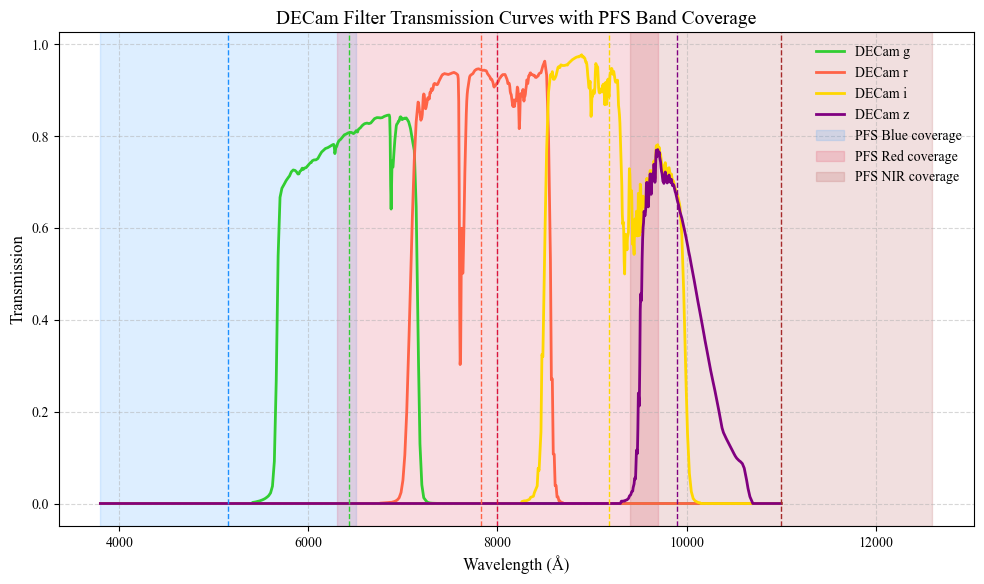

In [53]:
# Plot DECam transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='DECam g', color='limegreen', lw=2)
plt.plot(wav, filter_r, label='DECam r', color='tomato', lw=2)
plt.plot(wav, filter_i, label='DECam i', color='gold', lw=2)
plt.plot(wav, filter_z, label='DECam z', color='purple', lw=2)

# Plot CWL for Decam filters
plt.axvline(lam_eff_g, color='limegreen', ls='--', lw=1)
plt.axvline(lam_eff_r, color='tomato', ls='--', lw=1)
plt.axvline(lam_eff_i, color='gold', ls='--', lw=1)
plt.axvline(lam_eff_z, color='purple', ls='--', lw=1)

# Add shaded regions for PFS arms
for name, info in pfs_bands.items():
    x_min, x_max = info['range']
    plt.axvspan(x_min, x_max, color=info['color'], alpha=0.15, label=f"{name} coverage")
    plt.axvline(info['cwl'], color=info['color'], ls='--', lw=1)

# Plot formatting
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Transmission', fontsize=12)
plt.title('DECam Filter Transmission Curves with PFS Band Coverage', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [54]:
peak_luminosities.shape

(12, 11)

In [55]:
L_bol = np.array(peak_luminosities) * u.erg / u.s
print(f"L_bol shape: {L_bol.shape}")

# Source distance
dL = events["S250328ae"]["dL"] * u.Mpc
dL = dL.to(u.cm)
print(f"Source distance dL = {dL.to(u.Mpc):.2f}")
# Redshift
z = z_at_value(cosmo.luminosity_distance, dL)
print(f"Redshift z = {z:.3f}")

# Effective wavelengths (Å)
eff_wavelengths = {
    'DECam_g': lam_eff_g,
    'DECam_r': lam_eff_r,
    'DECam_i': lam_eff_i,
    'DECam_z': lam_eff_z,
    'PFS_blue': 5150,
    'PFS_red': 8000,
    'PFS_NIR': 11000,
}

# Runnoe et al. (2012) correction factors
runnoe_coeffs = {
    1450: {'C': 4.2},
    3000: {'C': 5.2},
    5100: {'C': 8.1},
}

def L_lambda_from_Lbol(Lbol, lam_eff):
    """Compute λLλ from Lbol using nearest Runnoe correction factor."""
    ref_wavelength = min(runnoe_coeffs.keys(), key=lambda w: abs(w - lam_eff))
    C = runnoe_coeffs[ref_wavelength]['C']
    return Lbol / C  # λLλ in erg/s

# Constants
c = 2.99792458e18  # speed of light in Å/s

# To Store results
magnitudes = {band: np.zeros(L_bol.shape) for band in eff_wavelengths.keys()}

# Main computation
for i in range(L_bol.shape[0]):      
    for j in range(L_bol.shape[1]):  
        Lbol = L_bol[i, j]

        for band, lam in eff_wavelengths.items():
            # λLλ (erg/s)
            L_lam = L_lambda_from_Lbol(Lbol, lam)

            # Lν (erg/s/Hz)
            L_nu = L_lam * (lam / c)

            # Fν at Earth (erg/s/cm²/Hz)
            F_nu = L_nu / (4 * np.pi * dL**2 * (1 + z))

            # AB magnitude
            m_AB = -2.5 * np.log10(F_nu.value) - 48.6

            # Store result
            magnitudes[band][i, j] = m_AB

print("Estimated observed AB magnitudes (DECam + PFS):")
for band, mags in magnitudes.items():
    print(f"{band:10s}  mean={np.nanmean(mags):6.2f}  min={np.nanmin(mags):6.2f}  max={np.nanmax(mags):6.2f}")

rows = []
for i in range(L_bol.shape[0]):
    for j in range(L_bol.shape[1]):
        row = {'event': i, 'sample': j}
        for band in magnitudes.keys():
            row[band] = magnitudes[band][i, j]
        rows.append(row)

mag_df = pd.DataFrame(rows)
print("\nDataFrame shape:", mag_df.shape)
mag_df

L_bol shape: (12, 11)
Source distance dL = 492.33 Mpc
Redshift z = 0.103 redshift
Estimated observed AB magnitudes (DECam + PFS):
DECam_g     mean= 16.31  min= -0.67  max= 31.23
DECam_r     mean= 16.10  min= -0.89  max= 31.02
DECam_i     mean= 15.92  min= -1.06  max= 30.85
DECam_z     mean= 15.84  min= -1.14  max= 30.76
PFS_blue    mean= 16.55  min= -0.43  max= 31.47
PFS_red     mean= 16.07  min= -0.91  max= 31.00
PFS_NIR     mean= 15.73  min= -1.26  max= 30.65

DataFrame shape: (132, 9)


event  sample   DECam_g    DECam_r    DECam_i    DECam_z   PFS_blue  \
0        0       0  -0.67363  -0.886699  -1.059737  -1.141804  -0.432273   
1        0       1   1.82637   1.613301   1.440263   1.358196   2.067727   
2        0       2   4.32637   4.113301   3.940263   3.858196   4.567727   
3        0       3   6.82637   6.613301   6.440263   6.358196   7.067727   
4        0       4   9.32637   9.113301   8.940263   8.858196   9.567727   
..     ...     ...       ...        ...        ...        ...        ...   
127     11       6  21.23251  21.019442  20.846404  20.764336  21.473868   
128     11       7  23.73251  23.519442  23.346404  23.264336  23.973868   
129     11       8  26.23251  26.019442  25.846404  25.764336  26.473868   
130     11       9  28.73251  28.519442  28.346404  28.264336  28.973868   
131     11      10  31.23251  31.019442  30.846404  30.764336  31.473868   

       PFS_red    PFS_NIR  
0    -0.910479  -1.256236  
1     1.589521   1.243764  
2     4.089521   3.743764  
3     6.589521   6.243764  
4     9.089521   8.743764  
..         ...        ...  
127  20.995661  20.649904  
128  23.495661  23.149904  
129  25.995661  25.649904  
130  28.495661  28.149904  
131  30.995661  30.649904  

[132 rows x 9 columns]

In [56]:
def mags_from_Lbol(L_bol_array, lam_eff, dL_cm, z):
    """Return AB magnitude array for a given band."""
    # 1. λLλ (erg/s)
    L_lam = L_lambda_from_Lbol(L_bol_array, lam_eff)
    
    # 2. Lν = Lλ * (λ / c)
    L_nu = L_lam * (lam_eff / c)
    
    # 3. Fν = Lν / (4π dL²)
    F_nu = L_nu / (4 * np.pi * dL_cm**2 * (1 + z))
    
    # 4. Convert to AB magnitude
    m_AB = -2.5 * np.log10(F_nu.value) - 48.6
    return m_AB

lam_i = eff_wavelengths['DECam_i']
lam_g = eff_wavelengths['DECam_g']
lam_r = eff_wavelengths['DECam_r']
lam_z = eff_wavelengths['DECam_z']
lam_pfs_blue = eff_wavelengths['PFS_blue']
lam_pfs_red = eff_wavelengths['PFS_red']
lam_pfs_nir = eff_wavelengths['PFS_NIR']

m_i = mags_from_Lbol(L_bol, lam_i, dL, z)
m_g = mags_from_Lbol(L_bol, lam_g, dL, z)
m_r = mags_from_Lbol(L_bol, lam_r, dL, z)
m_z = mags_from_Lbol(L_bol, lam_z, dL, z)
m_pfs_blue = mags_from_Lbol(L_bol, lam_pfs_blue, dL, z)
m_pfs_red = mags_from_Lbol(L_bol, lam_pfs_red, dL, z)
m_pfs_nir = mags_from_Lbol(L_bol, lam_pfs_nir, dL, z)

print(m_i[:5])

[[-1.05973697  1.44026303  3.94026303  6.44026303  8.94026303 11.44026303
  13.94026303 16.44026303 18.94026303 21.44026303 23.94026303]
 [ 0.60412865  3.10412865  5.60412865  8.10412865 10.60412865 13.10412865
  15.60412865 18.10412865 20.60412865 23.10412865 25.60412865]
 [ 1.70008892  4.20008892  6.70008892  9.20008892 11.70008892 14.20008892
  16.70008892 19.20008892 21.70008892 24.20008892 26.70008892]
 [ 2.51867244  5.01867244  7.51867244 10.01867244 12.51867244 15.01867244
  17.51867244 20.01867244 22.51867244 25.01867244 27.51867244]
 [ 3.17229876  5.67229876  8.17229876 10.67229876 13.17229876 15.67229876
  18.17229876 20.67229876 23.17229876 25.67229876 28.17229876]]


# Lightcurves

With customizations specifically for PFS-DESGW paper

In [57]:
# pfs epochs
pfs_epochs = {}
for event, data in events.items():
    if "pfs_obs_mjd" in data:  # check key exists
        start_time = Time(data["start"], format='iso')
        pfs_obs_times = Time(data["pfs_obs_mjd"], format='mjd')
        pfs_epochs[event] = (pfs_obs_times - start_time).to_value('day')

# Print results
pfs_epochs_list = []
for event, ep in pfs_epochs.items():
    pfs_epochs_list.append(ep)
    print(f"{event}: {ep}")

pfs_epochs_list , pfs_epochs

S250328ae: [6.]


([array([6.])], {'S250328ae': array([6.])})

In [58]:
values_decam = [
    {"z": 21.4, "r": 22.7, "i": 22.1},
    {"z": 21.9, "r": 22.8, "i": 22.5},
    {"z": 21.0, "r": 21.3, "i": 21.2},
    {"z": 21.6, "r": 22.3, "i": 22.1},
]

values_pfs = [
    {"blue": 21.3, "red": 21.3, "nir": 19.6}
]
obs_depths_decam = dict(zip(epochs[-1], values_decam))
obs_depths_pfs = dict(zip(pfs_epochs_list[-1], values_pfs))
print("DECam Depths:", obs_depths_decam)
print("PFS Depths:", obs_depths_pfs)

DECam Depths: {1.0: {'z': 21.4, 'r': 22.7, 'i': 22.1}, 2.0: {'z': 21.9, 'r': 22.8, 'i': 22.5}, 9.0: {'z': 21.0, 'r': 21.3, 'i': 21.2}, 28.0: {'z': 21.6, 'r': 22.3, 'i': 22.1}}
PFS Depths: {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [59]:
peak_times.shape, sig_start_times.shape, end_times.shape, peak_luminosities.shape

((12, 11), (12, 11), (12, 11), (12, 11))

In [60]:
vk_array.shape, rho_array.shape

((12,), (11,))

In [61]:
%%time
for i, event in enumerate(events.keys()):
    model_dict = {}

    for a in range(len(vk_array)):
        for b in range(len(rho_array)):

            # ---------- Time and Luminosity Information ----------
            if peak_times[a, b] > end_times[a, b]: 
                peak_times[a, b] = end_times[a, b]

            times = np.array([
                sig_start_times[a, b],
                peak_times[a, b],
                end_times[a, b]
            ])

            t_rise, t_fall, lumi_rise, lumi_fall = light_curve_model(
                times, peak_luminosities[a, b]
            )

            # ---------- Conversion to magnitudes in each band ----------
            mag_rise_g = mags_from_Lbol(lumi_rise, lam_g, dL, z)
            mag_fall_g = mags_from_Lbol(lumi_fall, lam_g, dL, z)
            mag_rise_r = mags_from_Lbol(lumi_rise, lam_r, dL, z)
            mag_fall_r = mags_from_Lbol(lumi_fall, lam_r, dL, z)
            mag_rise_i = mags_from_Lbol(lumi_rise, lam_i, dL, z)
            mag_fall_i = mags_from_Lbol(lumi_fall, lam_i, dL, z)
            mag_rise_z = mags_from_Lbol(lumi_rise, lam_z, dL, z)
            mag_fall_z = mags_from_Lbol(lumi_fall, lam_z, dL, z)
            mag_rise_pfs_blue = mags_from_Lbol(lumi_rise, lam_pfs_blue, dL, z)
            mag_fall_pfs_blue = mags_from_Lbol(lumi_fall, lam_pfs_blue, dL, z)
            mag_rise_pfs_red = mags_from_Lbol(lumi_rise, lam_pfs_red, dL, z)
            mag_fall_pfs_red = mags_from_Lbol(lumi_fall, lam_pfs_red, dL, z)
            mag_rise_pfs_nir = mags_from_Lbol(lumi_rise, lam_pfs_nir, dL, z)
            mag_fall_pfs_nir = mags_from_Lbol(lumi_fall, lam_pfs_nir, dL, z)

            # ---------- Combine rise and fall parts ----------
            time_g = np.concatenate([t_rise, t_fall])
            mag_g = np.concatenate([mag_rise_g, mag_fall_g])
            time_r = np.concatenate([t_rise, t_fall])
            mag_r = np.concatenate([mag_rise_r, mag_fall_r])
            time_i = np.concatenate([t_rise, t_fall])
            mag_i = np.concatenate([mag_rise_i, mag_fall_i])
            time_z = np.concatenate([t_rise, t_fall])
            mag_z = np.concatenate([mag_rise_z, mag_fall_z])
            time_pfs_blue = np.concatenate([t_rise, t_fall])
            mag_pfs_blue = np.concatenate([mag_rise_pfs_blue, mag_fall_pfs_blue])
            time_pfs_red = np.concatenate([t_rise, t_fall])
            mag_pfs_red = np.concatenate([mag_rise_pfs_red, mag_fall_pfs_red])
            time_pfs_nir = np.concatenate([t_rise, t_fall])
            mag_pfs_nir = np.concatenate([mag_rise_pfs_nir, mag_fall_pfs_nir])  

            # ---------- Sort by time ----------
            idx_g = np.argsort(time_g)
            idx_r = np.argsort(time_r)
            idx_i = np.argsort(time_i)
            idx_z = np.argsort(time_z)
            idx_pfs_blue = np.argsort(time_pfs_blue)
            idx_pfs_red = np.argsort(time_pfs_red)
            idx_pfs_nir = np.argsort(time_pfs_nir)

            # ---------- Save this model's data ----------

            def scientific_to_latex(val):
                """Convert float in scientific notation to LaTeX-friendly 10^x format."""
                exponent = int(np.floor(np.log10(abs(val))))
                base = val / 10**exponent
                # Round base if needed (often it's 1.0 so you can omit)
                if np.isclose(base, 1.0):
                    return f"10^{{{exponent}}}"
                else:
                    return f"{base:.1f} \\times 10^{{{exponent}}}"

            rho_val = rho_array[b]
            rho_str = scientific_to_latex(rho_val)
            model_id = (
                        f"$v_k={vk_array[a]}km/s$\n"
                        f"$\\rho={rho_str}g/cm^3$\n"
                    )

            model_dict[model_id] = {
                'g': (time_g[idx_g], mag_g[idx_g]),
                'r': (time_r[idx_r], mag_r[idx_r]),
                'i': (time_i[idx_i], mag_i[idx_i]),
                'z': (time_z[idx_z], mag_z[idx_z]),
                'PFS_Blue': (time_pfs_blue[idx_pfs_blue], mag_pfs_blue[idx_pfs_blue]),
                'PFS_Red': (time_pfs_red[idx_pfs_red], mag_pfs_red[idx_pfs_red]),
                'PFS_NIR': (time_pfs_nir[idx_pfs_nir], mag_pfs_nir[idx_pfs_nir]),
                'params': {
                    'vk': vk_array[a],
                    'rho': rho_array[b],
                }
            }
    model_dict['event'] = event
    model_dict['start'] = events[event]["start"]
    model_dict['dL'] = events[event]["dL"]
    model_dict['chirp_mass'] = events[event]["chirp_mass"]

    # ---------- Save the full model dictionary ----------
    with open(f'model_lightcurves_dict_{event}_DECam_PFS_QSO_SED.pkl', 'wb') as f:
        pickle.dump(model_dict, f)

    print(f"Saved model lightcurves for event {event} with {len(model_dict)} models.")

Saved model lightcurves for event S250328ae with 136 models.
CPU times: user 149 ms, sys: 3.42 ms, total: 152 ms
Wall time: 108 ms


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16791/1100245319.py:13: RuntimeWarning: divide by zero encountered in log10
  m_AB = -2.5 * np.log10(F_nu.value) - 48.6


In [62]:
len(model_dict)

136

In [63]:
# Load one event's model dict
event = list(events.keys())[0]  
with open(f'model_lightcurves_dict_{event}_DECam_PFS_QSO_SED.pkl', 'rb') as f:
    model_dict = pickle.load(f)

model_dict

{'$v_k=100km/s$\n$\\rho=10^{-3}g/cm^3$\n': {'g': (array([ 59.36      ,  59.95959596,  60.55919192,  61.15878788,
           61.75838384,  62.3579798 ,  62.95757576,  63.55717172,
           64.15676768,  64.75636364,  65.3559596 ,  65.95555556,
           66.55515152,  67.15474747,  67.75434343,  68.35393939,
           68.95353535,  69.55313131,  70.15272727,  70.75232323,
           71.35191919,  71.95151515,  72.55111111,  73.15070707,
           73.75030303,  74.34989899,  74.94949495,  75.54909091,
           76.14868687,  76.74828283,  77.34787879,  77.94747475,
           78.54707071,  79.14666667,  79.74626263,  80.34585859,
           80.94545455,  81.54505051,  82.14464646,  82.74424242,
           83.34383838,  83.94343434,  84.5430303 ,  85.14262626,
           85.74222222,  86.34181818,  86.94141414,  87.5410101 ,
           88.14060606,  88.74020202,  89.33979798,  89.93939394,
           90.5389899 ,  91.13858586,  91.73818182,  92.33777778,
           92.93737374,  93.5

In [64]:
# Paramter space compared to obs depths
# Find brightest (minimum) magnitude in each band
bands_decam = ['r','i','z'] 
bands_pfs = ['blue', 'red', 'nir']
brightest = {band: min(d[band] for d in values_decam) for band in bands_decam}
brightest.update({band: min(d[band] for d in values_pfs) for band in bands_pfs})

print(brightest)


{'r': 21.3, 'i': 21.2, 'z': 21.0, 'blue': 21.3, 'red': 21.3, 'nir': 19.6}


In [65]:
obs_depths_decam, obs_depths_pfs

({1.0: {'z': 21.4, 'r': 22.7, 'i': 22.1},
  2.0: {'z': 21.9, 'r': 22.8, 'i': 22.5},
  9.0: {'z': 21.0, 'r': 21.3, 'i': 21.2},
  28.0: {'z': 21.6, 'r': 22.3, 'i': 22.1}},
 {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}})

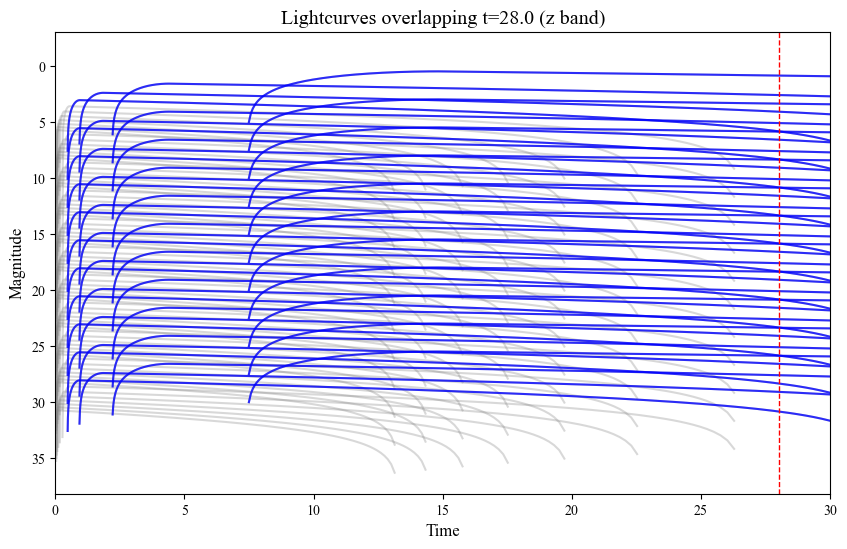

Number of lightcurves overlapping t=28.0: 44


In [66]:
target_time = 28.0
tolerance = 0.2

plt.figure(figsize=(10, 6))

count = 0

# Plot all lightcurves in gray first
for model_id, model in model_dict.items():
    if isinstance(model, dict) and 'z' in model:
        time_z, mag_z = model['z']
        plt.plot(time_z, mag_z, color='gray', alpha=0.3)

# Highlight lightcurves overlapping with the first vertical line
for model_id, model in model_dict.items():
    if isinstance(model, dict) and 'z' in model:
        time_z, mag_z = model['z']
        if any(abs(time_z - target_time) < tolerance):
            plt.plot(time_z, mag_z, color='blue', alpha=0.8)
            count += 1

# Draw the first vertical line
plt.axvline(x=target_time, color='red', linestyle='--', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.xlim(0, 30)
plt.title(f'Lightcurves overlapping t={target_time} (z band)')
plt.gca().invert_yaxis()
plt.show()

print(f"Number of lightcurves overlapping t={target_time}: {count}")


In [67]:
target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
tolerance = 0.1

overlap_counts = []

for t in target_times:
    count = 0
    for model_id, model in model_dict.items():
        if isinstance(model, dict) and 'z' in model:
            time_z, mag_z = model['z']
            if any(abs(time_z - t) < tolerance):
                count += 1
    overlap_counts.append(count)

for t, count in zip(target_times, overlap_counts):
    print(f"Number of lightcurves overlapping t={t}: {count}")


Number of lightcurves overlapping t=1.0: 99
Number of lightcurves overlapping t=2.0: 66
Number of lightcurves overlapping t=6.0: 99
Number of lightcurves overlapping t=9.0: 99
Number of lightcurves overlapping t=28.0: 33


Use PFS specific blackbody lightcurves for PFS epoch

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16791/405211827.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16791/405211827.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_16791/405211827.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r'

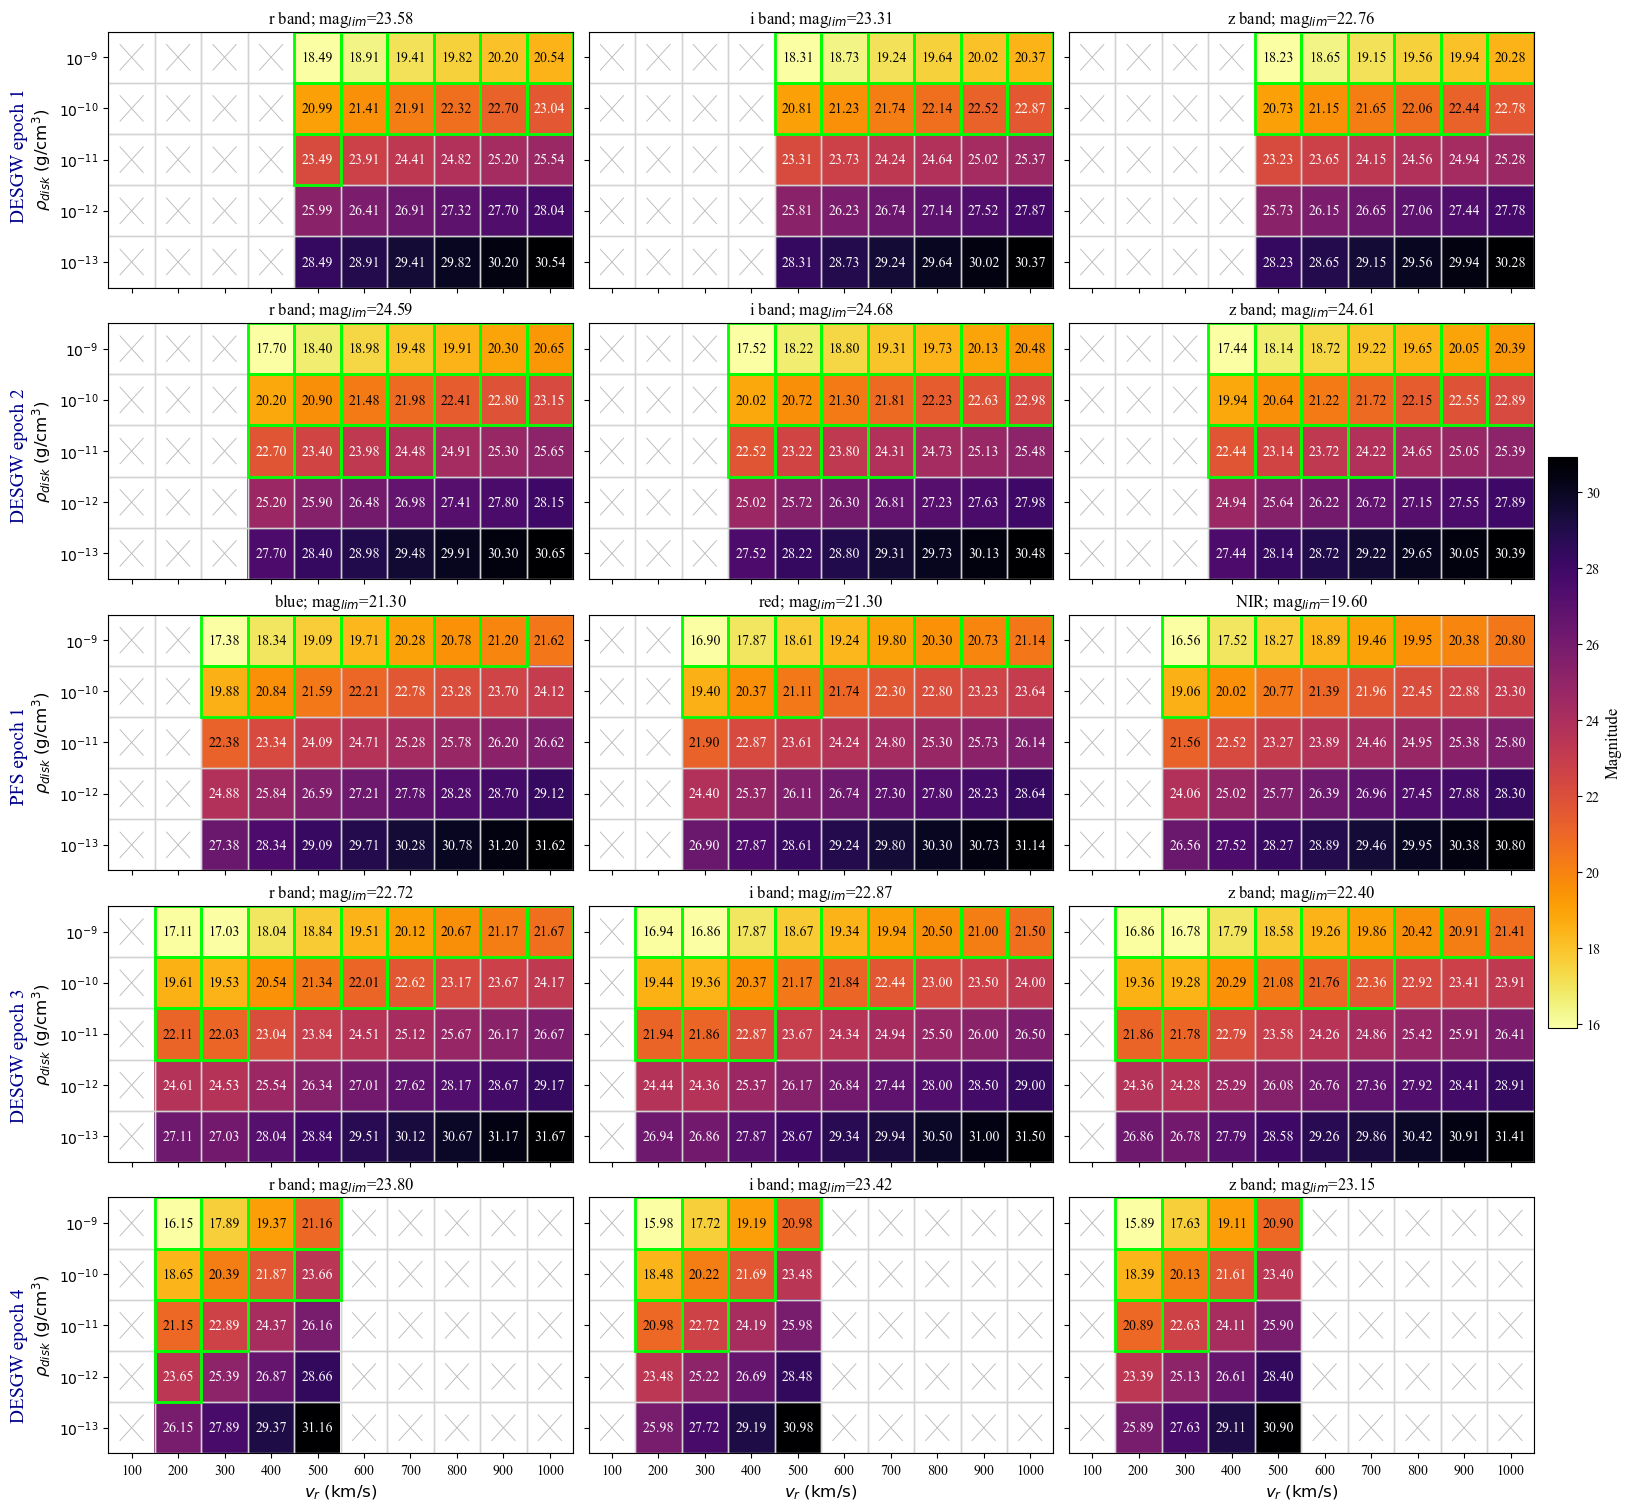

In [68]:
target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
depths = {
    #'r': [23.8, 23.8, None, 23.8, 23.8],
    #'i': [23.5, 23.5, None, 23.5, 23.5],
    #'z': [23.4, 23.4, None, 23.4, 23.4],
    'r': [23.58, 24.59, None, 22.72, 23.80],
    'i': [23.31, 24.68, None, 22.87, 23.42],
    'z': [22.76, 24.61, None, 22.4, 23.15],
    'PFS_Blue': [None, None, 21.3, None, None],
    'PFS_Red': [None, None, 21.3, None, None],
    'PFS_NIR': [None, None, 19.6, None, None]
}
tolerance = 0.2

vk_min = 100
vk_max = 1000
rho_min = 1e-13
rho_max = 1e-9

vk_values = sorted(set(
    entry['params']['vk']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))
rho_values = sorted(set(
    entry['params']['rho']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))

filtered_vk_values = [vk for vk in vk_values if vk_min <= vk <= vk_max]
filtered_rho_values = [rho for rho in rho_values if rho_min <= rho <= rho_max]

def format_rho(rho):
    exp = int(np.floor(np.log10(rho)))
    return f"$10^{{{exp}}}$"


plt.rcParams.update({
    
    "font.family": "serif",  # or "sans-serif" or "monospace"
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

fig, axes = plt.subplots(len(target_times), 3, figsize=(16, 3*len(target_times)), constrained_layout=True, sharex='col', sharey='row')

row_labels = ["DESGW epoch 1", "DESGW epoch 2", "PFS epoch 1", "DESGW epoch 3", "DESGW epoch 4"]

desgw_bands = ['r', 'i', 'z']
pfs_bands = ['PFS_Blue', 'PFS_Red', 'PFS_NIR']
desgw_titles = {'r': "r band", 'i': "i band", 'z': "z band"}
pfs_titles = {'PFS_Blue': "blue", 'PFS_Red': "red", 'PFS_NIR': "NIR"}
        

for t_idx, t in enumerate(target_times):
    # For the current row, select the correct bands and titles
    if t_idx == 2:
        bands = pfs_bands
        band_titles = pfs_titles
    else:
        bands = desgw_bands
        band_titles = desgw_titles
    for b_idx, band in enumerate(bands):
        mag_matrix = np.full((len(filtered_rho_values), len(filtered_vk_values)), np.nan, dtype=float)
        for model_id, model in model_dict.items():
            if isinstance(model, dict) and band in model:
                time_b, mag_b = model[band]
                idx = np.where(np.abs(time_b - t) < tolerance)[0]
                if len(idx) > 0:
                    vk = model['params']['vk']
                    rho = model['params']['rho']
                    mag = mag_b[idx[0]]
                    if (rho_min <= rho <= rho_max) and (vk_min <= vk <= vk_max):
                        i = filtered_rho_values.index(rho)
                        j = filtered_vk_values.index(vk)
                        if mag == np.inf:
                            mag_matrix[i, j] = np.nan
                        else:
                            mag_matrix[i, j] = mag

        ax = axes[t_idx, b_idx]
        im = ax.imshow(mag_matrix, origin='lower', aspect='auto', cmap='inferno_r')
        #ax.set_xlabel(r'$v_r$')
        #ax.set_ylabel(r'$\rho_{disk}$')
        #ax.set_title(f"{band_titles[band]}", fontsize=12)
        mag_lim = depths[band][t_idx]
        if mag_lim is not None:
            limstr = f"mag$_{{lim}}$={mag_lim:.2f}"
        else:
            limstr = "mag$_{lim}$=N/A"
        ax.set_title(f"{band_titles[band]}; {limstr}", fontsize=12)

        # Only show x labels on the bottom row
        if b_idx == 0:
            ax.set_ylabel(r'$\rho_{disk}\; (\text{g/cm}^3)$')
            #ax.tick_params(labelbottom=False)
        
        # Only show y labels on the leftmost column
        if t_idx == len(target_times) - 1:
            ax.set_xlabel(r'$v_r \; (\text{km/s})$')
            #ax.tick_params(labelleft=False)

        ax.set_xticks(np.arange(len(filtered_vk_values)))
        ax.set_xticklabels([f"{val:.0f}" for val in filtered_vk_values])
        ax.set_yticks(np.arange(len(filtered_rho_values)))
        ax.set_yticklabels([format_rho(val) for val in filtered_rho_values])

        norm = plt.Normalize(np.nanmin(mag_matrix), np.nanmax(mag_matrix))
        cmap = cm.get_cmap('inferno_r')

        '''for i in range(len(filtered_rho_values)):
            for j in range(len(filtered_vk_values)):
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1, edgecolor='lightgray', facecolor='none', zorder=1)
                ax.add_patch(rect)
                if not np.isnan(mag_matrix[i, j]):
                    mag = mag_matrix[i, j]
                    rgba = cmap(norm(mag))
                    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
                    text_color = 'white' if brightness < 0.5 else 'black'
                    ax.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=10)
                    if mag < depths[band][t_idx]:
                        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='lime', facecolor='none', zorder=2)
                        ax.add_patch(rect)
                    #elif mag_matrix[i, j] == 'inf':
                    #print(mag_matrix[i, j])
                    # Draw a very faint cross (X) in the empty cell for visual cue
                    #ax.plot([j-0.25, j+0.25], [i-0.25, i+0.25], color='#bbbbbb', lw=0.65, zorder=3)
                    #ax.plot([j-0.25, j+0.25], [i+0.25, i-0.25], color='#bbbbbb', lw=0.65, zorder=3)
                else:
                    # Draw a very faint cross (X) in the empty cell for visual cue
                    ax.plot([j-0.25, j+0.25], [i-0.25, i+0.25], color='#bbbbbb', lw=0.65, zorder=3)
                    ax.plot([j-0.25, j+0.25], [i+0.25, i-0.25], color='#bbbbbb', lw=0.65, zorder=3)'''
        
        for i in range(len(filtered_rho_values)):
            for j in range(len(filtered_vk_values)):
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1, edgecolor='lightgray', facecolor='none', zorder=1)
                ax.add_patch(rect)
                if not np.isnan(mag_matrix[i, j]):
                    mag = mag_matrix[i, j]
                    rgba = cmap(norm(mag))
                    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
                    text_color = 'white' if brightness < 0.50 else 'black'
                    ax.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=10)
                    if mag < depths[band][t_idx]:
                        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='lime', facecolor='none', zorder=2)
                        ax.add_patch(rect)
                else:
                    # Draw a very faint cross (X) in the empty cell for visual cue
                    ax.plot([j-0.25, j+0.25], [i-0.25, i+0.25], color='#bbbbbb', lw=0.65, zorder=3)
                    ax.plot([j-0.25, j+0.25], [i+0.25, i-0.25], color='#bbbbbb', lw=0.65, zorder=3)
    # Add row label (epoch) to the left of the row of subplots
    fig.text(0.001, 1 - (t_idx + 0.5) / len(target_times), row_labels[t_idx], va='center', ha='right', fontsize=14, color='darkblue', rotation=90)

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label='Magnitude')


plt.savefig('lightcurve_heatmaps_DECam_PFS.jpeg', dpi=600, bbox_inches='tight')
plt.show()